# Imports and GCP Setup

In [26]:
# Import libraries 
import yaml
import string
import requests

# Recall from the APIs for Data lab that including passwords in code is a terrible practice. 
# So we include a yaml file.
config_file = open('GCP_model_details.yaml', 'r')
config = yaml.safe_load(config_file)

In [27]:
!source GCP_modeling_setup.sh

Setting up envirement variables
Done

Setting project up
Updated property [core/project].
Done

Enabling APIs
Operation "operations/acat.p2-679997314711-da5c84c7-a4f3-4a67-ad2c-fcf715baacff" finished successfully.
Done

Making a bucket, if it exists, returns error
Creating gs://bookish-journey-clustering/...
ServiceException: 409 A Cloud Storage bucket named 'bookish-journey-clustering' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Done



## Modeling

In [1]:
import numpy as np
import pandas as pd
import pathlib

In [2]:
# From sklearn importing DictVectorizer: Transforms lists of feature-value mappings to vectors.
# Importing KernelPCA: Kernel Principal component analysis (KPCA).
# Importing itertools provides various functions that work on iterators. 

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import KernelPCA
import itertools

In [3]:
%%bigquery base

SELECT 
    idDrink,
    strDrink,
    strIngredient1,
    strIngredient2,
    strIngredient3,
    strIngredient4,
    strIngredient5,
    strIngredient6,
    strIngredient7,
    strIngredient8,
    strIngredient9,
    strIngredient10,
    strIngredient11,
    strIngredient12,
    strIngredient13,
    strIngredient14,
    strIngredient15
FROM `bookish-journey-343419.cocktails_dataset.cocktails-table`

Downloading: 100%|██████████| 425/425 [00:00<00:00, 563.79rows/s]


In [4]:
base.tail()

,idDrink,strDrink,strIngredient1,strIngredient2,strIngredient3,strIngredient4,strIngredient5,strIngredient6,strIngredient7,strIngredient8,strIngredient9,strIngredient10,strIngredient11,strIngredient12,strIngredient13,strIngredient14,strIngredient15
420,11991,Queen Elizabeth,Dry Vermouth,Gin,Benedictine,None,None,None,None,None,None,None,None,None,None,None,None
421,12910,Egg Nog #4,Egg yolk,Sugar,Milk,Light rum,Bourbon,Vanilla extract,Salt,Whipping cream,Egg white,Sugar,Nutmeg,None,None,None,None
422,12768,Frappé,Coffee,Milk,Sugar,None,None,None,None,None,None,None,None,None,None,None,None
423,17225,Ace,Gin,Grenadine,Heavy cream,Milk,Egg White,None,None,None,None,None,None,None,None,None,None
424,17241,Zombie,Rum,Gold rum,151 proof rum,Pernod,Grenadine,Lime Juice,Angostura Bitters,None,None,None,None,None,None,None,None


In [5]:
# Drop empty columns
base = base.drop(['strIngredient12','strIngredient13','strIngredient14','strIngredient15'],axis=1)

## Feature Engineering

In [6]:
# Replace NaN with ""
base = base.replace(np.nan,"")

In [7]:
# Create a ner variable, ingredients, that has all the previous ingredients together. 
base['ingredients'] = base[['strIngredient1','strIngredient2','strIngredient3','strIngredient4','strIngredient5',
        'strIngredient6','strIngredient7','strIngredient8','strIngredient9','strIngredient10','strIngredient11']].agg(','.join, axis=1)
base.ingredients.head()

0    Gin,Carbonated water,Powdered sugar,Orange spi...
1    Egg,Sugar,Condensed milk,Milk,Vanilla extract,...
2                   Advocaat,Lemonade,Lemon,Ice,,,,,,,
3                  Espresso,Honey,Cocoa powder,,,,,,,,
4                           Sugar,Lime,Cachaca,,,,,,,,
Name: ingredients, dtype: object

In [8]:
# Function to transform letters to lowercase.

def lower(text):
    text=text.lower()
    return text

# Pass all words throw the funtion and append them
ingredients_low=[]
for i in base.ingredients:
    il=lower(i)
    ingredients_low.append(il)

base['ingredients']=ingredients_low
base.ingredients

0      gin,carbonated water,powdered sugar,orange spi...
1      egg,sugar,condensed milk,milk,vanilla extract,...
2                     advocaat,lemonade,lemon,ice,,,,,,,
3                    espresso,honey,cocoa powder,,,,,,,,
4                             sugar,lime,cachaca,,,,,,,,
                             ...                        
420                 dry vermouth,gin,benedictine,,,,,,,,
421    egg yolk,sugar,milk,light rum,bourbon,vanilla ...
422                            coffee,milk,sugar,,,,,,,,
423       gin,grenadine,heavy cream,milk,egg white,,,,,,
424    rum,gold rum,151 proof rum,pernod,grenadine,li...
Name: ingredients, Length: 425, dtype: object

In [9]:
# This function convert a list of ingredients into a dictionary, note: every ingredient gets a 1.
# this mean that the value of every key is 1. key:value

def convert_to_dict(lst):
    d = {} #empty dict
    for ingre in lst:
        d[ingre] = 1
    return d

# We use the function to convert every row into a dictionary. 
# 'vodka': 1, 'lime juice': 1... this will help us later to create a one hot encoding.
base['bagofwords'] = base.ingredients.str.split(',').apply(convert_to_dict)
print(base.bagofwords)

0      {'gin': 1, 'carbonated water': 1, 'powdered su...
1      {'egg': 1, 'sugar': 1, 'condensed milk': 1, 'm...
2      {'advocaat': 1, 'lemonade': 1, 'lemon': 1, 'ic...
3      {'espresso': 1, 'honey': 1, 'cocoa powder': 1,...
4           {'sugar': 1, 'lime': 1, 'cachaca': 1, '': 1}
                             ...                        
420    {'dry vermouth': 1, 'gin': 1, 'benedictine': 1...
421    {'egg yolk': 1, 'sugar': 1, 'milk': 1, 'light ...
422          {'coffee': 1, 'milk': 1, 'sugar': 1, '': 1}
423    {'gin': 1, 'grenadine': 1, 'heavy cream': 1, '...
424    {'rum': 1, 'gold rum': 1, '151 proof rum': 1, ...
Name: bagofwords, Length: 425, dtype: object


In [10]:
# One Hot Encoding
# To find similarities between dishes and cluster cocktails using their ingredients, we will represent a recipe by a one-hot encoded vector 
# of its ingredients. We will be establishing a vocabulary of ingredients using a method ‘DictVectorizer’ provided in the sklearn library

# DictVectorizer:This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators.
# sparse, default=True. Whether transform should produce scipy.sparse matrices. In this case we set it as False.

vector_dict = DictVectorizer(sparse = False)

# fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. 
#The fit method is calculating the mean and variance of each of the features present in our data. 
#The transform method is transforming all the features using the respective mean and variance.
# We past every dictionary into a list.
X = vector_dict.fit_transform(base["bagofwords"].tolist())

# We select the column strDrink(name of the drink) from the dataset
y = base.strDrink

## Training a Model: Mean Shift Clustering

In [11]:
# Using Kernel PCA
# kernel = "cosine": This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

kpca = KernelPCA(n_components=6,kernel="cosine", n_jobs=2)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. 
#Thus, the parameters learned by our model using the training data will help us to transform our test data.
x_pca = kpca.fit_transform(X)

In [12]:
from sklearn.cluster import KMeans
ms = KMeans().fit(x_pca)

In [40]:
# Recommendations
def cluster_recomm(index,algorithm = ms,n_return = 5):
    cluster = algorithm.predict(x_pca[index].reshape(1, -1))[0]
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = algorithm.labels_
    in_cluster = cluster_map[cluster_map.cluster == cluster].sample(n=n_return, random_state = 42)
    return y[in_cluster.index]

In [41]:
cluster_recomm(index = 6,algorithm = ms,n_return = 3)

163    Dubonnet Cocktail
397          Munich Mule
390           Gin Rickey
Name: strDrink, dtype: object

## Saving Model

In [42]:
import joblib
from google.cloud import storage
import datetime

In [43]:
# Export the model to a file
model = 'model.joblib'
joblib.dump(ms, model)

['model.joblib']

In [44]:
# Public bucket holding the census data
bucket = storage.Client().bucket(config['bucket_name'])

# Upload the model to GCS
bucket = storage.Client().get_bucket(bucket)
blob = bucket.blob("KMeans/" + model)
blob.upload_from_filename(model)

# Sending Model to Vertex AI

In [48]:
!source GCP_Deploying_Kmeans.sh

Setting up envirement variables
Done

Uploading Model
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8390182535010713600]...done.                            
Done

Creating endpoint
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2855258592972374016]...done.                            
Created Vertex AI endpoint: projects/679997314711/locations/us-central1/endpoints/1009202140716990464.
Done

Deploying Model
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1369070715940110336]...done.                            
Deployed a model to the endpoint 1688401259519803392. Id of the deployed model: 4321828365066567680.
Done



## Metrics

The **Elbow method** helps to select the optimal number of clusters by fitting the model with a range of values for $K$. If the line chart resembles an arm, then the *elbow* (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. 

In the visualizer *elbow* is annotated with a dashed line, according to this method the best number of clusters is 5.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


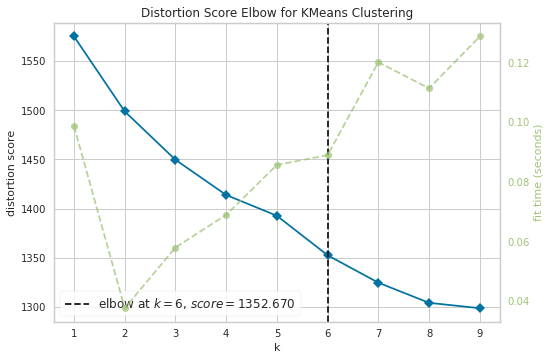

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The **Silhouette Coefficient** is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering.

The Silhouette Visualizer displays the silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not. This is particularly useful for determining cluster imbalance, or for selecting a value for 𝐾 by comparing multiple visualizers. 
In this case, the average Silhouette is around 0.05.

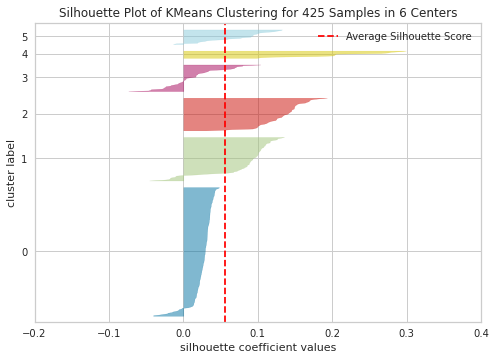

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 425 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**Intercluster distance maps** display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


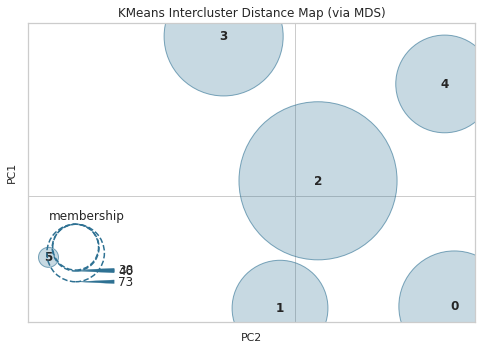

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [17]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure